In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/india-air-quality-index2024-dataset/data_aqi_cpcb.xml


In [ ]:
import xml.etree.ElementTree as ET
import csv

#Parses the XML file
tree = ET.parse('/kaggle/input/india-air-quality-index2024-dataset/data_aqi_cpcb.xml')
root = tree.getroot()

#Opens a CSV file for writing
with open('AQI.csv', 'w', newline = '', encoding = 'utf-8') as csvfile:
    writer = csv.writer(csvfile)

    #Writes the header
    header = [
        "Country", "State", "City", "Station", "Latitude", "Longitude", "Last Update",
        "Pollutant", "Min", "Max", "Avg", "AQI", "Predominant Parameter"
    ]
    writer.writerow(header)

    #Iterates through the XML structure and write rows
    for country in root.findall('Country'):
        country_id = country.get('id')
        for state in country.findall('State'):
            state_id = state.get('id')
            for city in state.findall('City'):
                city_id = city.get('id')
                for station in city.findall('Station'):
                    station_id = station.get('id')
                    latitude = station.get('latitude')
                    longitude = station.get('longitude')
                    last_update = station.get('lastupdate')

                    #Pollutant details
                    for pollutant in station.findall('Pollutant_Index'):
                        pollutant_id = pollutant.get('id')
                        min_val = pollutant.get('Min')
                        max_val = pollutant.get('Max')
                        avg_val = pollutant.get('Avg')

                        #Defaults AQI details to empty
                        aqi_value = ""
                        predominant_param = ""

                        #Checks for AQI details
                        aqi = station.find('Air_Quality_Index')
                        if aqi is not None:
                            aqi_value = aqi.get('Value')
                            predominant_param = aqi.get('Predominant_Parameter')

                        #Writes a row to the CSV
                        writer.writerow([
                            country_id, state_id, city_id, station_id, latitude, longitude,
                            last_update, pollutant_id, min_val, max_val, avg_val,
                            aqi_value, predominant_param
                        ])

print("XML data has been successfully converted to CSV!")

XML data has been successfully converted to CSV!


In [ ]:
AQI = pd.read_csv('AQI.csv')

In [ ]:
AQI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3285 entries, 0 to 3284
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Country                3285 non-null   object 
 1   State                  3285 non-null   object 
 2   City                   3285 non-null   object 
 3   Station                3285 non-null   object 
 4   Latitude               3285 non-null   float64
 5   Longitude              3285 non-null   float64
 6   Last Update            3285 non-null   object 
 7   Pollutant              3285 non-null   object 
 8   Min                    3065 non-null   float64
 9   Max                    3065 non-null   float64
 10  Avg                    3065 non-null   float64
 11  AQI                    3042 non-null   float64
 12  Predominant Parameter  3042 non-null   object 
dtypes: float64(6), object(7)
memory usage: 333.8+ KB


In [ ]:
AQI.head()

,Country,State,City,Station,Latitude,Longitude,Last Update,Pollutant,Min,Max,Avg,AQI,Predominant Parameter
0,India,Andhra_Pradesh,Amaravati,"Secretariat, Amaravati - APPCB",16.515083,80.518167,20-11-2023 12:00:00,PM2.5,NaN,NaN,NaN,NaN,NaN
1,India,Andhra_Pradesh,Amaravati,"Secretariat, Amaravati - APPCB",16.515083,80.518167,20-11-2023 12:00:00,PM10,NaN,NaN,NaN,NaN,NaN
2,India,Andhra_Pradesh,Amaravati,"Secretariat, Amaravati - APPCB",16.515083,80.518167,20-11-2023 12:00:00,SO2,NaN,NaN,NaN,NaN,NaN
3,India,Andhra_Pradesh,Amaravati,"Secretariat, Amaravati - APPCB",16.515083,80.518167,20-11-2023 12:00:00,CO,NaN,NaN,NaN,NaN,NaN
4,India,Andhra_Pradesh,Amaravati,"Secretariat, Amaravati - APPCB",16.515083,80.518167,20-11-2023 12:00:00,OZONE,NaN,NaN,NaN,NaN,NaN


## Data Cleaning

<Axes: xlabel='State'>

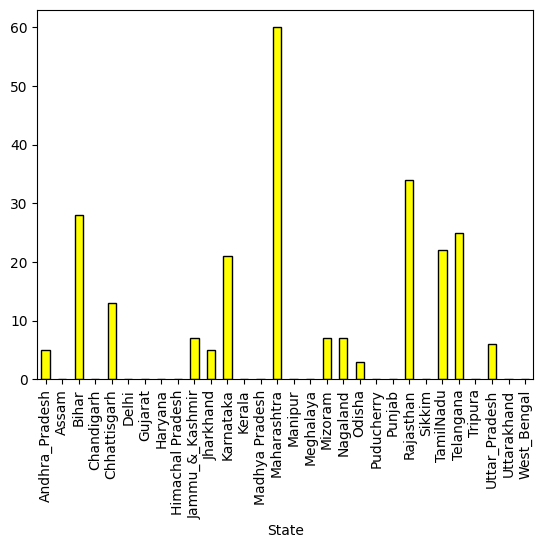

In [ ]:
State_data_missing = AQI.groupby('State')['AQI'].apply(lambda x: x.isnull().sum())
State_data_missing.plot(kind='bar',color='yellow',edgecolor='black')

In [ ]:
# Fill the missing values
AQI['AQI'] = AQI.groupby(['State', 'Pollutant'])['AQI'].transform(lambda x: x.fillna(x.mean()))
AQI['Avg'] = AQI.groupby('State')['Avg'].transform(lambda x: x.fillna(x.mean()))
AQI['Min'] = AQI.groupby('State')['Min'].transform(lambda x: x.fillna(x.mean()))
AQI['Max'] = AQI.groupby('State')['Max'].transform(lambda x: x.fillna(x.mean()))

In [ ]:
AQI['Predominant Parameter'] = AQI.groupby('State')['Predominant Parameter'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown')
)

In [ ]:
AQI_cleaned = AQI.dropna(subset=['AQI', 'Pollutant'])

In [ ]:
AQI_cleaned.head()

,Country,State,City,Station,Latitude,Longitude,Last Update,Pollutant,Min,Max,Avg,AQI,Predominant Parameter
0,India,Andhra_Pradesh,Amaravati,"Secretariat, Amaravati - APPCB",16.515083,80.518167,20-11-2023 12:00:00,PM2.5,16.871429,38.914286,25.128571,48.1,CO
1,India,Andhra_Pradesh,Amaravati,"Secretariat, Amaravati - APPCB",16.515083,80.518167,20-11-2023 12:00:00,PM10,16.871429,38.914286,25.128571,48.1,CO
2,India,Andhra_Pradesh,Amaravati,"Secretariat, Amaravati - APPCB",16.515083,80.518167,20-11-2023 12:00:00,SO2,16.871429,38.914286,25.128571,48.1,CO
3,India,Andhra_Pradesh,Amaravati,"Secretariat, Amaravati - APPCB",16.515083,80.518167,20-11-2023 12:00:00,CO,16.871429,38.914286,25.128571,48.1,CO
4,India,Andhra_Pradesh,Amaravati,"Secretariat, Amaravati - APPCB",16.515083,80.518167,20-11-2023 12:00:00,OZONE,16.871429,38.914286,25.128571,48.1,CO


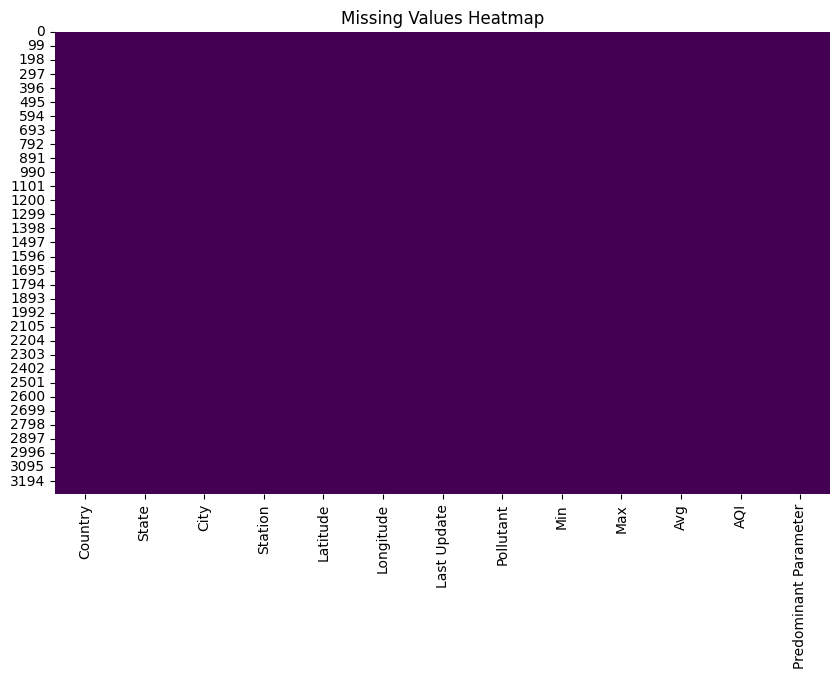

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(AQI_cleaned.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [ ]:
unique_pollutants = AQI['Pollutant'].unique()
print("Unique Pollutants:")
print(unique_pollutants)

Unique Pollutants:
['PM2.5' 'PM10' 'SO2' 'CO' 'OZONE' 'NO2' 'NH3']


In [ ]:
unique_parameters = AQI['Predominant Parameter'].unique()
print("\nUnique Predominant Parameters:")
print(unique_parameters)


Unique Predominant Parameters:
['CO' 'OZONE' 'PM2.5' 'PM10' 'NO2' 'Unknown' 'SO2']


## Data Visualization

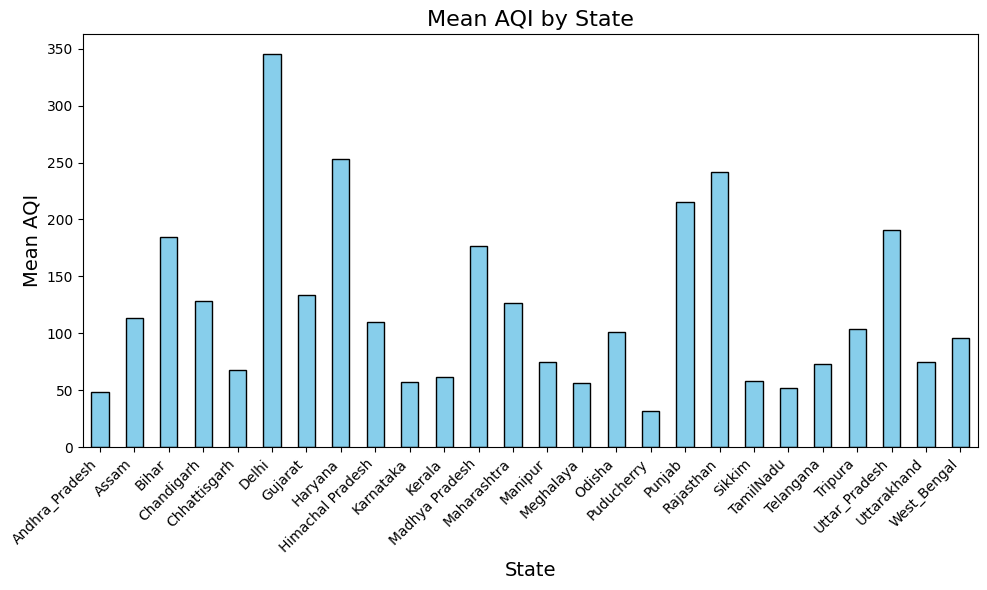

In [ ]:
plt.figure(figsize=(10, 6))
State_data = AQI_cleaned['AQI'].groupby(AQI['State']).mean()
State_data.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Mean AQI by State', fontsize=16)
plt.xlabel('State', fontsize=14)
plt.ylabel('Mean AQI', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

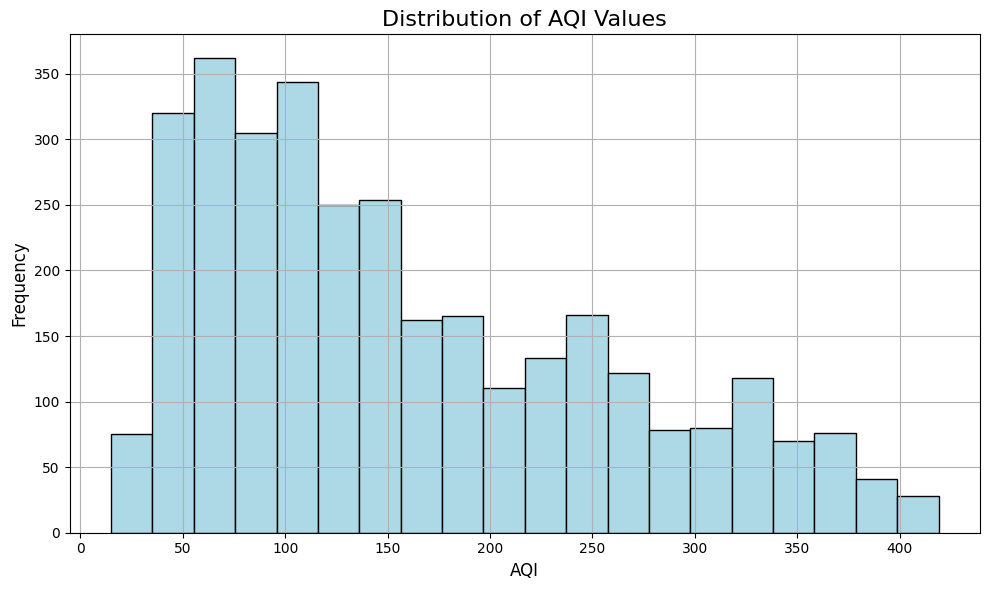

In [ ]:
plt.figure(figsize=(10, 6))
AQI_cleaned['AQI'].hist(bins=20, color='lightblue', edgecolor='black')
plt.title('Distribution of AQI Values', fontsize=16)
plt.xlabel('AQI', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

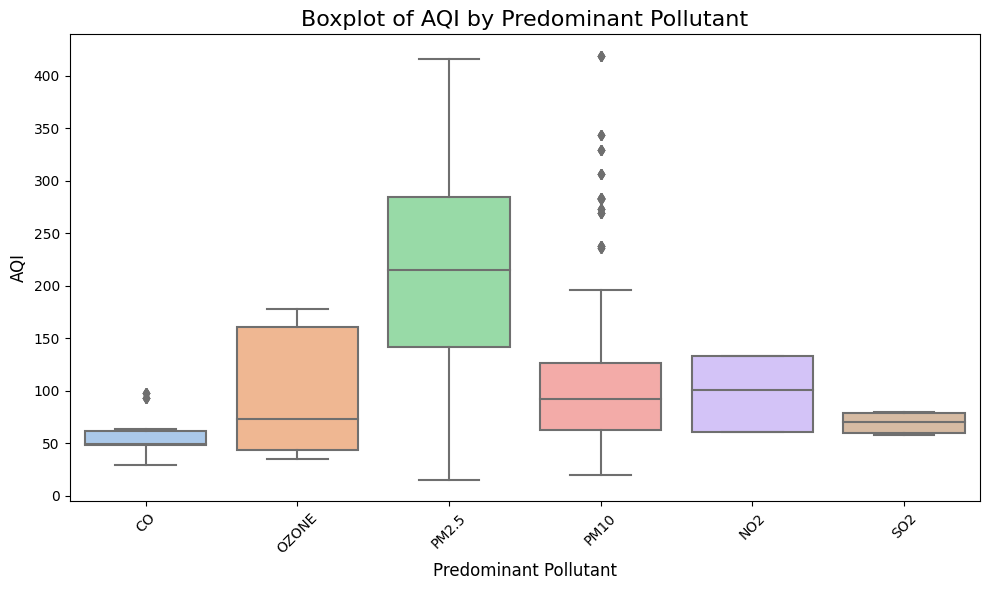

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Predominant Parameter', y='AQI', data=AQI_cleaned, palette='pastel')
plt.title('Boxplot of AQI by Predominant Pollutant', fontsize=16)
plt.xlabel('Predominant Pollutant', fontsize=12)
plt.ylabel('AQI', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

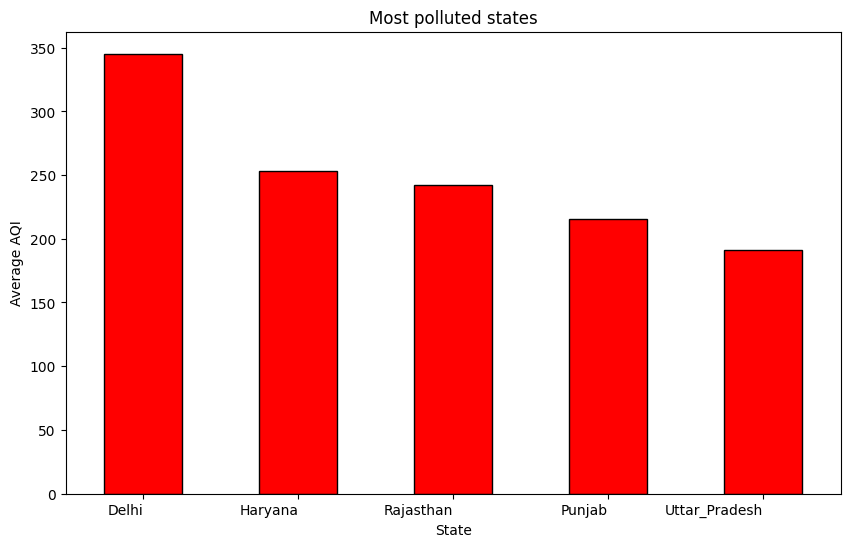

In [ ]:
# Top 5 most polluted states
Top_5 = State_data.sort_values(ascending = False).head(5)

plt.figure(figsize=(10,6))
Top_5.plot(kind='bar',color='red',edgecolor='black')
plt.title('Most polluted states')
plt.xlabel("State")
plt.ylabel("Average AQI")
plt.xticks(rotation=0, ha='right')
plt.show()

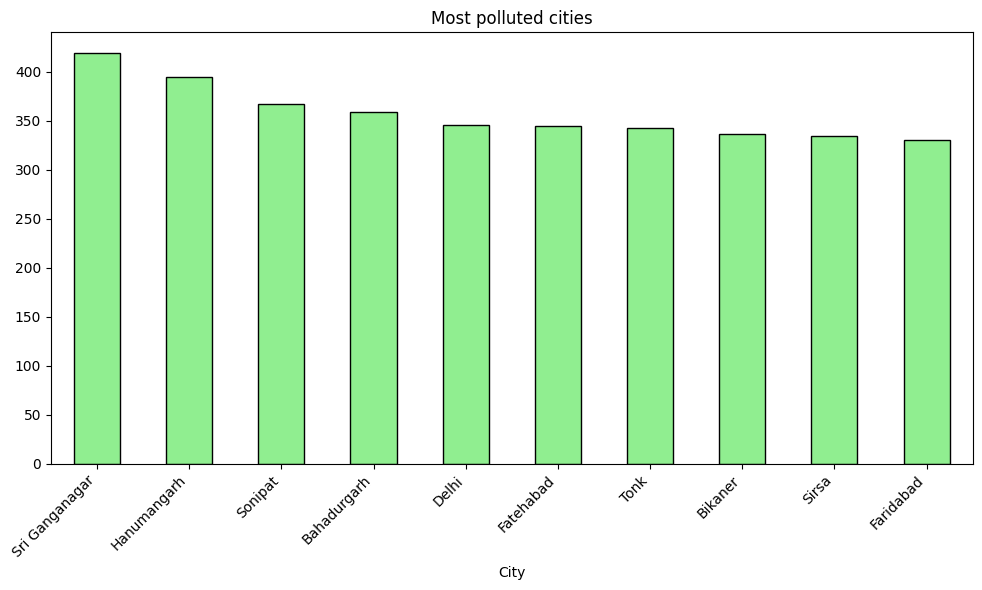

In [ ]:
City_data = AQI_cleaned.groupby('City')['AQI'].mean()
Most_polluted_cities = City_data.sort_values(ascending=False).head(10)
plt.figure(figsize=(10,6))
Most_polluted_cities.plot(kind='bar',color='lightgreen',edgecolor='black')
plt.title('Most polluted cities')
plt.xlabel('City')
plt.xticks(rotation=45,ha='right')
plt.tight_layout()
plt.show()

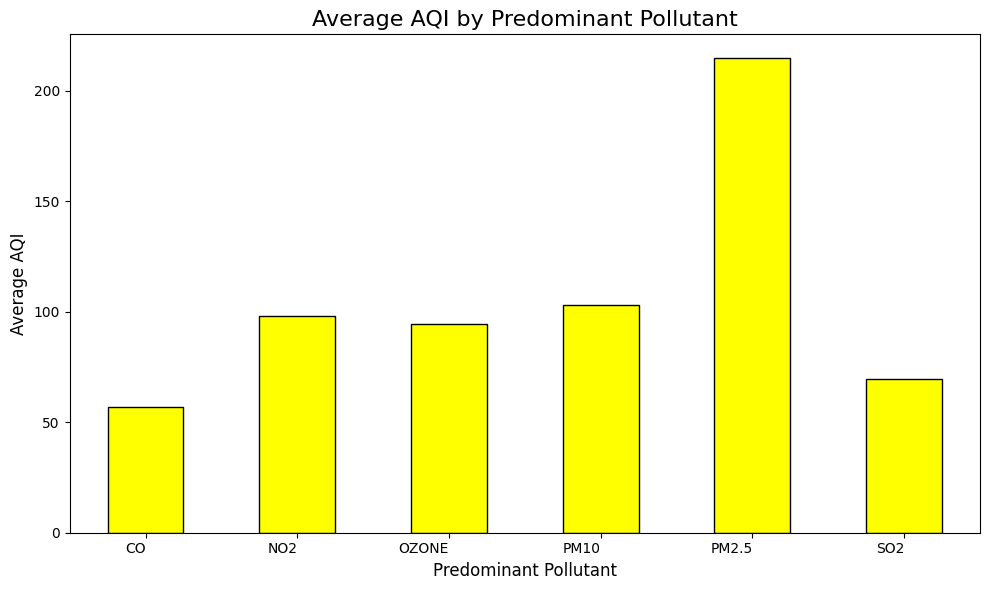

In [ ]:
Pollutant = AQI_cleaned.groupby('Predominant Parameter')['AQI'].mean()
plt.figure(figsize=(10, 6))
Pollutant.plot(kind='bar',color='yellow',edgecolor='black')
plt.title('Average AQI by Predominant Pollutant', fontsize=16)
plt.xlabel('Predominant Pollutant', fontsize=12)
plt.ylabel('Average AQI', fontsize=12)
plt.xticks(rotation=0,ha='right')
plt.tight_layout()
plt.show()

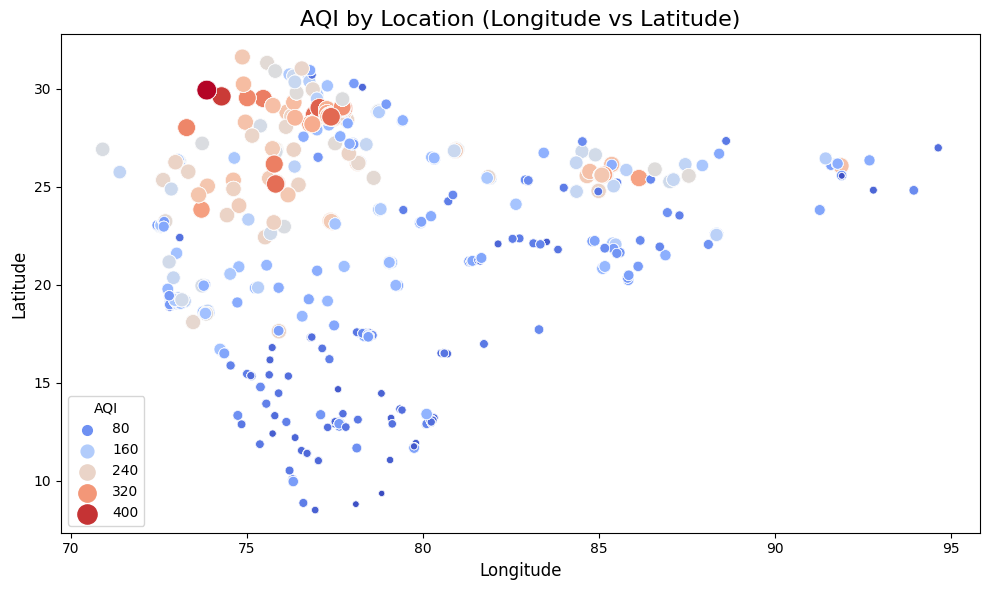

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Longitude', y='Latitude', hue='AQI', data=AQI_cleaned, palette='coolwarm', size='AQI', sizes=(20, 200))
plt.title('AQI by Location (Longitude vs Latitude)', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.tight_layout()
plt.show()

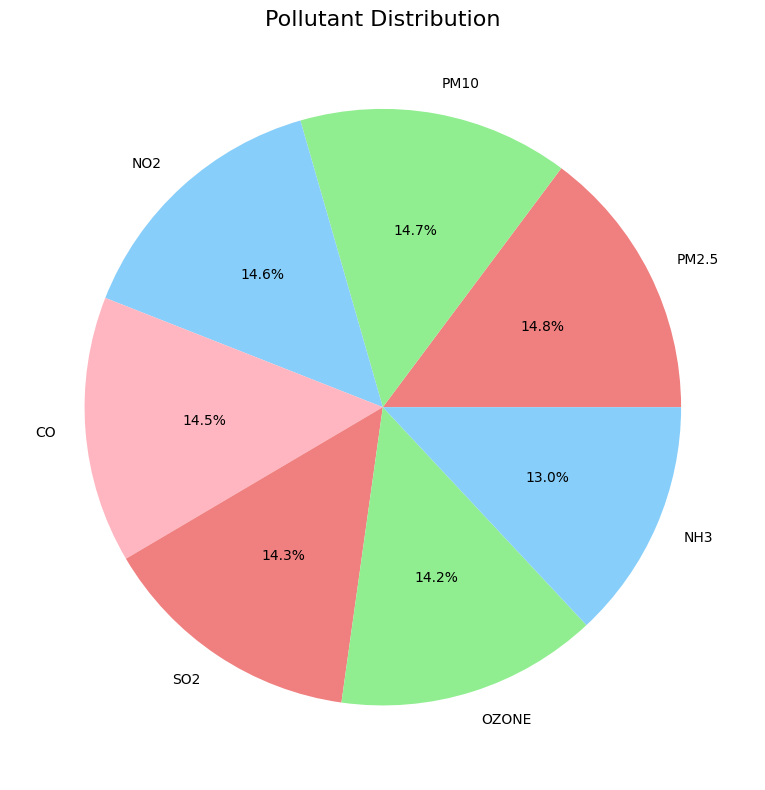

In [ ]:
pollutant_counts = AQI_cleaned['Pollutant'].value_counts()
plt.figure(figsize=(8, 8))
pollutant_counts.plot(kind='pie', autopct='%1.1f%%', colors=['lightcoral', 'lightgreen', 'lightskyblue', 'lightpink'])
plt.title('Pollutant Distribution', fontsize=16)
plt.ylabel('')
plt.tight_layout()
plt.show()

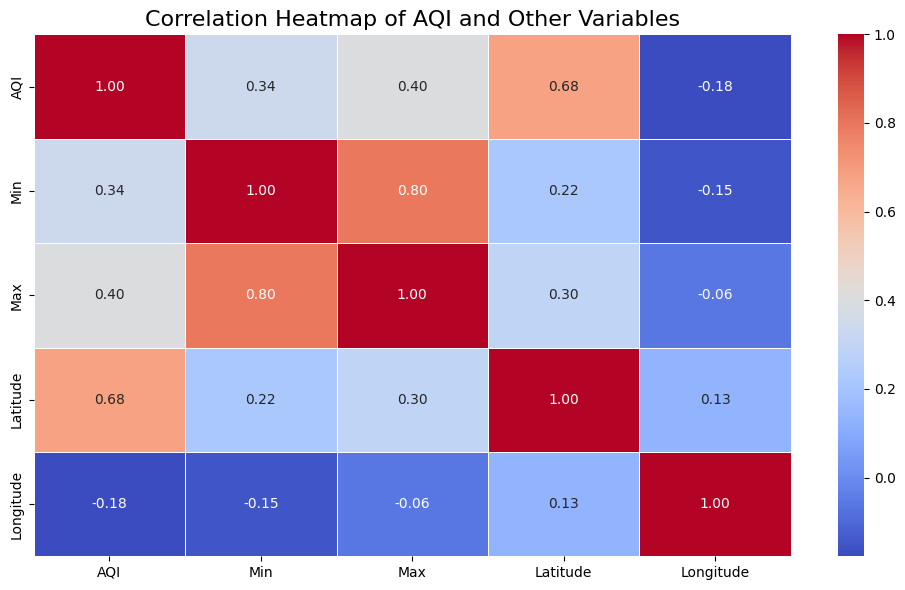

In [ ]:
plt.figure(figsize=(10, 6))
correlation_matrix = AQI_cleaned[['AQI', 'Min', 'Max', 'Latitude', 'Longitude']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of AQI and Other Variables', fontsize=16)
plt.tight_layout()
plt.show()

## Splitting the data

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [ ]:
label_encoder = LabelEncoder()
AQI_cleaned['Pollutant'] = label_encoder.fit_transform(AQI_cleaned['Pollutant'])
AQI_cleaned['Predominant Parameter'] = label_encoder.fit_transform(AQI_cleaned['Predominant Parameter'])

/tmp/ipykernel_30/3219282793.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AQI_cleaned['Pollutant'] = label_encoder.fit_transform(AQI_cleaned['Pollutant'])
/tmp/ipykernel_30/3219282793.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AQI_cleaned['Predominant Parameter'] = label_encoder.fit_transform(AQI_cleaned['Predominant Parameter'])


In [ ]:
X = AQI_cleaned[['Latitude', 'Longitude', 'Pollutant', 'Min', 'Max', 'Predominant Parameter']]
y = AQI_cleaned['AQI']

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Prediction of AQI

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
print(y_pred[0:10])

[126.88445946  49.14       246.8        156.82       184.31142857
 199.67271504 193.8105     270.75        82.64        37.31      ]


In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display the results
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-Squared: {r2}')

Mean Absolute Error: 6.65345464344898
Mean Squared Error: 163.0296906438365
R-Squared: 0.9822775109572951


In [ ]:
# Saving the model
import pickle

with open('/kaggle/working/model.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Model saved successfully!")

Model saved successfully!


In [ ]:
def single_prediction(user_input):

    user_input_reshaped = np.array(user_input).reshape(1, -1)
    scaled_input = scaler.fit_transform(user_input_reshaped)
    prediction = model.predict(scaled_input)

    return prediction[0]

def get_user_input():
    print("Enter the following details for AQI prediction:")

    latitude = float(input("Enter Latitude: "))
    longitude = float(input("Enter Longitude: "))
    pollutant = input("Enter Pollutant (e.g., PM2.5, PM10, CO, SO2, etc.): ")
    min_value = float(input("Enter Min value: "))
    max_value = float(input("Enter Max value: "))
    predominant_parameter = input("Enter Predominant Parameter (e.g., CO, NO2, etc.): ")


    encoded_pollutant = label_encoder.transform([pollutant])[0]
    encoded_predominant_parameter = label_encoder.transform([predominant_parameter])[0]


    user_input = [latitude, longitude, encoded_pollutant, min_value, max_value, encoded_predominant_parameter]

    return user_input

user_input = [16.589, 32.678, 3, 18.78, 32.467, 4]
predicted_aqi = single_prediction(user_input)
print(f"The predicted AQI is: {predicted_aqi:.2f}")

The predicted AQI is: 107.40
